<a href="https://colab.research.google.com/github/kaavlu/TreeHacks2024/blob/main/Final_whisperaitranscribe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!sudo apt update && sudo apt install ffmpeg
!pip install moviepy
!pip install whisper-timestamped
!pip install matplotlib
!pip install opencv-python-headless
!pip install torch torchvision transformers opencv-python-headless deepface
!pip install python-magic-bin

from google.colab import drive
from moviepy.editor import VideoFileClip
from transformers import pipeline
from deepface import DeepFace
from transformers import pipeline
import whisper_timestamped as whisper
import json
import cv2

drive.mount("/content/drive/", force_remount=True)

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,834 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,742 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univers

In [3]:
!pip install SpeechRecognition
!pip install pydub

import speech_recognition as sr
from os import path
from pydub import AudioSegment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 43.8 MB/s eta 0:00:00


In [4]:
import whisper_timestamped
# transcripts.py
def convert_mp4_to_mp3(mp4_file_path, mp3_file_path):
    # Load the MP4 file
    video_clip = VideoFileClip(mp4_file_path)

    # Extract the audio from the video clip
    audio_clip = video_clip.audio

    # Write the audio to an MP3 file
    audio_clip.write_audiofile(mp3_file_path)

    # Close the video and audio clips
    video_clip.close()
    audio_clip.close()

def transcriptionData(mp4_file_path, mp3_file_path):
  # mp4_file_path = video_path
  # mp3_file_path = "/content/drive/MyDrive/TreeHacks2024/trim.mp3"
  convert_mp4_to_mp3(mp4_file_path, mp3_file_path)

  audio = whisper.load_audio(mp3_file_path)

  # train model small (good balance of time + accuracy)
  model = whisper.load_model("small", device="cuda")

  # saves data to json
  result = whisper.transcribe(model, audio, language="en")
  json_str = json.dumps(result, indent = 2, ensure_ascii = False)
  data = json.loads(json_str)

  # converts to dict
  segments_info = []
  for segment in data["segments"]:
      segment_info = {
          "id": segment["id"],
          "text": segment["text"],
          "start": segment["start"],
          "end": segment["end"]
      }
      segments_info.append(segment_info)

  return segments_info

def generateTWeights(segments_info):
  #classifier to generate weights
  classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
  weights = [];

  #generate weights per sentence
  for segment in segments_info:
    text = segment["text"]
    d = classifier(text)
    sorted_output = [sorted(sublist, key=lambda x: x['score'], reverse=True) for sublist in d]
    score = sorted_output[0][0]['score']
    label = sorted_output[0][0]['label']
    if(label == "neutral" and score > 0.5):
      weights.append(0)
    else:
      weights.append(score)

  return weights


In [5]:
def normalize_emotion_values(emotion_result):
    # Extract the 'emotion' map from the emotion result
    emotion_map = emotion_result[0]['emotion']
    # Calculate the sum of all probabilities
    total_probability = sum(emotion_map.values())
    # Normalize each emotion value so that they sum up to 1
    normalized_emotion_map = {emotion: value / total_probability for emotion, value in emotion_map.items()}
    return normalized_emotion_map
def analyze_emotions(video_path, tDataRaw):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    # Variables to keep track of frame count and second count
    frame_count = 0
    second_count = 0
    emotions_list = []
    startList = [segment['start'] for segment in tDataRaw]
    endList = [segment['end'] for segment in tDataRaw]
    # Process video frame by frame
    max = 0
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Increment frame count
        frame_count += 1
        # If one second has passed, analyze the emotion of the first frame in that second
        if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 1:
            second_count += 1
            if i < len(tDataRaw):
              result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
              normalized_result = normalize_emotion_values(result)
              domEmotion = result[0]['dominant_emotion']
              domValue = result[0]['emotion'][domEmotion] / 100.0
              if(second_count >= startList[i] and second_count < endList[i]):
                if(domValue > max):
                  domValue = max
              else:
                emotions_list.append(domValue)
                max = 0
                i+=1
            else:
              break

    cap.release()
    cv2.destroyAllWindows()
    return emotions_list

In [6]:
from datetime import datetime
# readable dict for chats
def time_to_seconds(timestamp_str):
    parts = timestamp_str.split('T')
    date_part = parts[0].split('-')
    time_part = parts[1].replace('Z', '').split(':')

    year, month, day = map(int, date_part)
    hour, minute, second = map(float, time_part)

    total_seconds = ((hour * 3600) + (minute * 60) + second)
    total_seconds += ((day * 24 * 3600) + (month * 30 * 24 * 3600) + (year * 365 * 24 * 3600))

    return round(total_seconds, 3)

def generateMessageDict(file_path):
  with open(file_path, 'r') as file:
      data = json.load(file)

  message_dict = []
  output_file_path = "/content/drive/MyDrive/TreeHacks2024/output.json"
  ftrue = True
  fElem = 0.000
  for comment in data["comments"]:
    if(ftrue):
      fElem = time_to_seconds(comment["created_at"])
      message_info = {
        "text" : comment["message"]["fragments"][0]["text"],
        "time" : 0.000
      }
      ftrue = False
    else:
      x = float(time_to_seconds(comment["created_at"])) - fElem
      message_info = {
          "text" : comment["message"]["fragments"][0]["text"],
          "time" : x
      }
    message_dict.append(message_info)

  return message_dict



In [7]:
mp4path = "/content/drive/MyDrive/TreeHacks/long.mp4"
mp3path = "/content/drive/MyDrive/TreeHacks/audiolong.mp3"
chats_file_path = "/content/drive/MyDrive/TreeHacks/chat.json"

tWeights = []
tDataRaw = transcriptionData(mp4path, mp3path)
tWeights = generateTWeights(tDataRaw)

mWeights = []
fWeights = []

MoviePy - Writing audio in /content/drive/MyDrive/TreeHacks/audiolong.mp3


MoviePy - Done.


100%|███████████████████████████████████████| 461M/461M [00:28<00:00, 16.8MiB/s]
100%|██████████| 180003/180003 [02:47<00:00, 1077.34frames/s]


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [8]:
# generates raw transcript data
mWeights = []
startNum = float(tDataRaw[0]['start'])
endNum = float(tDataRaw[1]['end'])
t = (startNum, endNum)

# generates readable chat data
messageData = generateMessageDict(chats_file_path)

messages = [item['text'] for item in messageData]

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

for item in tDataRaw:
  # transcript start/end time
  startTime = item["start"]
  endTime = item["end"]

  # store relevant messages
  recentMessages = []
  for message in messageData:
    mTime = message["time"]
    if ((float(mTime) >= startTime) and (float(mTime) < endTime)):
      recentMessages.append(message["text"])

  # classify relevant messages
  model_outputs = classifier(recentMessages)
  maxVal = 0
  for output in model_outputs:
    if(output[0]['score'] > maxVal):
      maxVal = output[0]['score']

  mWeights.append(output[0]['score'])

#print(tWeights)
# print(mWeights)
# print(fWeights)

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [9]:
fWeights = analyze_emotions(mp4path, tDataRaw)

24-02-18 14:36:26 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 36.1MB/s]


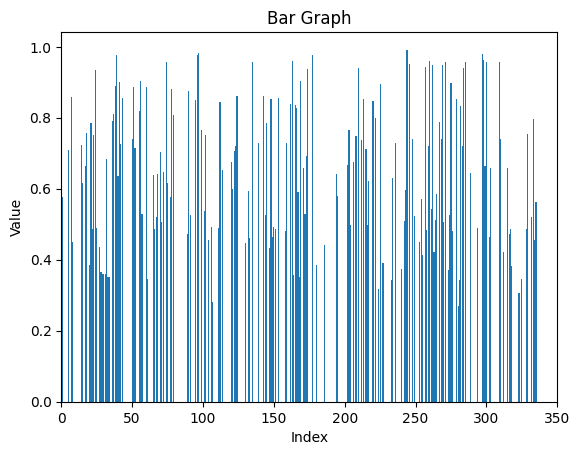

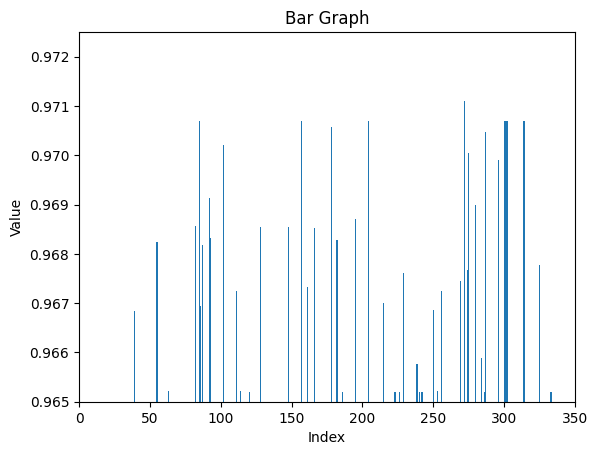

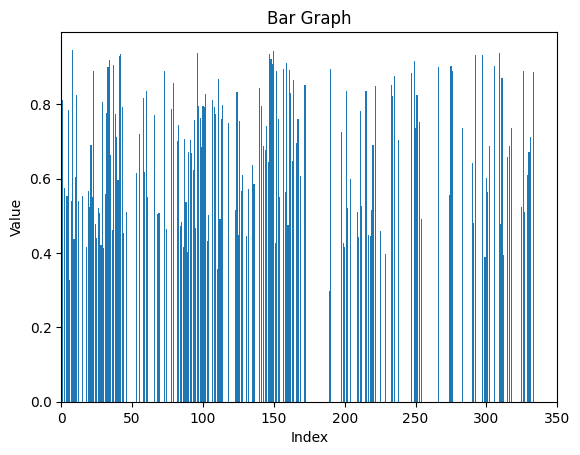

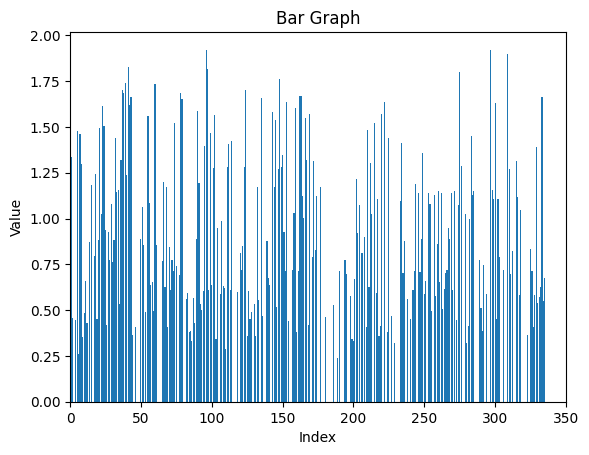

In [11]:
import matplotlib.pyplot as plt
# print(t[0])
# print(t[1])
# print(tDataRaw)
# print(tWeights)
# print(fWeights)
# composedArr = []
# for i in range(0, len(tWeights)):
#   composedArr.append(tWeights[i] + fWeights[i])
# print(composedArr)
def generate_bar_graph(data):
    # Generate x values (indices of data)
    x_values = range(len(data))

    # Plot the bar graph
    plt.bar(x_values, data)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Graph')
    plt.xlim(0, 350)
    # Show the plot
    plt.show()

mCopy = mWeights[:]
fCopy = fWeights[:]

for i in mCopy:
  if i < 0.965:
    i = 0

for i in range(len(fWeights)):
  if fCopy[i] > 0.95:
    fCopy[i] = 0

generate_bar_graph(tWeights)
# generate_bar_graph(mWeights)
plt.ylim(0.965, 0.9725)
generate_bar_graph(mWeights)
generate_bar_graph(fCopy)

composedArr = []
for i in range(0, len(tWeights)):
  composedArr.append(tWeights[i]*1.2 + fCopy[i]*0.8)
generate_bar_graph(composedArr)

In [12]:
import numpy as np

indices = np.argsort(composedArr)[-8:]

# Print the 4 highest values and their indices
print("Four highest values:", [composedArr[i] for i in indices])
print("Indices of four highest values:", indices)

for index in indices:
    print(tDataRaw[index])

Four highest values: [1.7423566204570953, 1.7611851052105627, 1.799749231338501, 1.8170608802644415, 1.8260274171829223, 1.8985746145248412, 1.9215728819834788, 1.9216253725863108]
Indices of four highest values: [ 39 148 275  97  41 309  96 297]
{'id': 39, 'text': ' The worst', 'start': 357.96, 'end': 358.44}
{'id': 148, 'text': ' Every third like in a great condition because it was wonderful. Yeah, thank you', 'start': 898.86, 'end': 903.42}
{'id': 275, 'text': " Who's that?", 'start': 1450.26, 'end': 1450.86}
{'id': 97, 'text': " Be angry and you're angry", 'start': 618.44, 'end': 620.22}
{'id': 41, 'text': " No, I'm not free now, sorry", 'start': 363.82, 'end': 365.4}
{'id': 309, 'text': ' Oh my god', 'start': 1639.48, 'end': 1640.06}
{'id': 96, 'text': ' Turn around turn around be angry fit turn around turn around be angry be angry', 'start': 611.4, 'end': 616.06}
{'id': 297, 'text': " I don't want to live alone actually", 'start': 1582.52, 'end': 1584.64}
